# Phonon

<a id='section_1'></a>
## 1. Introduction
### 1.1 What is phonon?
**Essentially, a phonon is the vibration mode of atoms in the crystal.** 
Before we go to the concepts, let's look at what is a phonon from this [website](http://henriquemiranda.github.io/phononwebsite/phonon.html). 

<figure style="width:600px">
    <img src="../assets/phonon-0-play-with-phonon.gif"/>
    <figcaption>Animation visualization of phonon. Cite from <a href="http://henriquemiranda.github.io/phononwebsite/phonon.html">http://henriquemiranda.github.io/phononwebsite/phonon.html</a>.</figcaption>
</figure>


Let's open the website -> select `Si` in the left-upper `materials` column -> click any point in right figure, i.e. `phonon dispersion`.
Then, you can see every atoms (yellow balls) in the middle window show periodic motion, and collection movement of all atoms seem like a wave that travels from one end to another.

Such a vibration mode in the crystal is called lattice vibration. Lattice vibration is usually dealed with quantum effects and it is called phonon. In this tutorial explanation, we don't distinguish the term lattice vibration and phonon. Please refer appendix & reference books for more detail.

The direction of wave propagration is usually represented by a vector $\vec q$ (called wave vector). The most important problem in the phonon analysis is to know what kind of vibration modes are allowed for a given wave vector $\vec q$, and the frequency of atomic vibration in those vibration modes.

Phonon is a kind of [quasiparticle](https://en.wikipedia.org/wiki/Quasiparticle). It has energy ($E$) and momentum ($\mathbf{p}$). The phonon in a solid is directly related to its thermal and acoustic properties. For example, the excitation of a phonon causes the increase of internal energy ($U$); the transportation of the phonon causes the conduction of sound and heat. As a consequence, the phonon analysis has been a very important simulation tool to obtain the properties of solid.

### 1.2 How to calculate the phonon frequency?

Similar with the vibration analysis (Chapter 4-1), the phonon is also calculated with the harmonic approximation. However, the atom interacts with those in the neigboring unit cell in the crystal. By considering the periodical boundary condition, the potential energy of a small distorted crystal structure can be expressed as:

$$ V(\mathbf{r}) \approx V(\mathbf{r_0}) +　\frac{1}{2} \sum_{ij} \frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^a \partial r_j^b} \Delta \mathbf{r}_i^a \Delta \mathbf{r}_j^b $$

where, $r_i^a$ indicates the coordination of the $i$-th atom at the $a$-th supercell. The force constant (explained in the Chapter 4.1) of a crystal should be a $3NM \times 3NM$ matrix, where $N$ is number of atoms per unit cell and $M$ is the number of unit cell to be considered. The force constant can be a very large martix.

We assume that the atomic displacement from its equilibrium position $u$ in a vibration mode in the crystal should have the following form (plane-wave like function)

$$ u(\vec R, t) = A e^{ \vec{q} \vec{R} -i\omega_{m} t} $$

Then, the large force constant matrix can be converted into a $3N \times 3N$ dynamical matrix by discrete Fourier transform in the real space. The dynamical matrix depends on the wave vector $\vec q$. The eigenvalue and eigenvector of the dynamical matrix is the vibration frequencies and vibration modes of the phonon. For the detailed explanation of phonon calculation formula, please refer to the [appendix](#section_5.1).

In the next section, we show how to calculate the phonon properties using the `matlantis-features` package. Some important concepts of phonon are introduced at the same time.

<a id='section_2'></a>
## 2. Example: phonon calculation of Si

### 2.1 Material preparation

Here, we use crystal silicon as an example to run the phonon calculation. As the first step, we should relax the crystal structure. Usually, we use the primitive cell of the crystal to calculate phonon dispersion since it contains the least number of atoms.

In [1]:
import numpy as np
np.set_printoptions(precision=3)

from ase.build import bulk
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v2.0.0")
calculator = ASECalculator(estimator)
atoms = bulk("Si")
atoms.calc = calculator

exp = ExpCellFilter(atoms)
BFGS(exp).run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 01:30:05       -9.092463        0.4849
BFGS:    1 01:30:05       -9.097614        0.0140
BFGS:    2 01:30:05       -9.097622        0.0002


True

### 2.2 Calculation of force constant matrix

Same with the vibration analysis, the force constant is necessary for calculating the vibration frequencies of phonon. 
Here, we obtain the force constant of the crystal using the `ForceConstantFeature`. 

The primitive cell of crystal Si contains only 2 atoms. We should repeat the unit cell many times to obtain the accurate result. It is because the force constant element $\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^a \partial r_j^b} $ will decay with the distance between atoms $i$ of unit cell $a$ and the atoms $j$ of unit cell $b$. Only if the supercell is large enough, all non-negligible elements of the force constant matrix can be included. In this example, we expand the crystal Si structure by 10x10x10 time.

The `ForceConstantFeature` in `matlantis-features` is used to compute the force constant of crystal silicon.

In [2]:
from matlantis_features.features.phonon import ForceConstantFeature

fc = ForceConstantFeature(
    supercell = (10,10,10),
    delta = 0.1,
)
force_constant = fc(atoms)
print(force_constant.force_constant.shape)

(1000, 6, 6)


The calculation result, i.e. force constant $C$, is a 1000x6x6 tensor. 

In [3]:
print(force_constant.force_constant[1])

[[-0.221 -0.215 -0.054  0.005 -0.01   0.051]
 [-0.215 -0.221 -0.054 -0.01   0.005  0.051]
 [ 0.054  0.054  0.396  0.051  0.051 -0.2  ]
 [-3.086 -2.142  2.142 -0.221 -0.215  0.054]
 [-2.142 -3.086  2.142 -0.215 -0.221  0.054]
 [ 2.142  2.142 -3.086 -0.054 -0.054  0.396]]


The `force_constant.force_constant[1]` is a 6x6 tensor. It is the force constant between the first and second unit cell $C^{1,2}$, i.e. $\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^1 \partial r_j^2} $.
Same as the vibration analysis, the element of $C^{1,2}$ is approximated with finite differences method.

$$C^{1,2}[i,j]=\frac{\partial^2 V(\mathbf{r_0})}{\partial r_i^1 \partial r_j^2} \approx \frac{F(\mathbf{r_0} + \Delta r_i^1)_j^2 - F(\mathbf{r_0})_j^2}{|\Delta{r_i^1}|} $$

Since we used 10x10x10 unit cells, we should have 1000x1000 such 6x6 matrix. However, the crystal has trasnlational invarince, which makes the $C^{a,b} = C^{0, b-a}$. Thus, we can represent the force constant with 1000x6x6 tensor.

### 2.3 Calculation of dynamical matrix

Unlike the molecular vibration, in which the vibration frequency is obtrain from digonlization of force constant $C$, the vibration frequency of crystal is the eigenvalue of the dynamical matrix $D_{\vec q}$, which is the discrete Fourier transform of the force constant in the real space. To obtain the dynamical matrix, we introduced another parameter, wave vector $\vec q$. 

Then, we use the `PhononFreqency` provided by `matlantis-features` to obtain the dynamical matrix of crystal silicon for the wave vector $\vec q = [0.1, 0.0, 0.0]$.

In [4]:
from matlantis_features.features.phonon.utils import PhononFrequency

phonon_frequency = PhononFrequency(
    force_constant.force_constant, force_constant.supercell, force_constant.unit_cell_atoms
)
dynamic_matrix = phonon_frequency._dynamic_matrix_q(np.array([0.1, 0.0, 0.0])).real
print("Dynamical matrix of q=[0.1, 0.0, 0.0]:")
print(dynamic_matrix)

Dynamical matrix of q=[0.1, 0.0, 0.0]:
[[ 0.436 -0.003 -0.003 -0.413 -0.012 -0.012]
 [-0.003  0.437  0.003 -0.012 -0.413  0.012]
 [-0.003  0.003  0.437 -0.012  0.012 -0.413]
 [-0.413 -0.012 -0.012  0.437 -0.003 -0.003]
 [-0.012 -0.413  0.012 -0.003  0.437  0.003]
 [-0.012  0.012 -0.413 -0.003  0.003  0.437]]


The dynamical matrix is a symmetric 6x6 matrix. It is calculated from the force constant $C$ with the following formula.
$$
\tilde{D}_{\vec{q}}[k\alpha, k'\beta] = \frac{1}{\sqrt{M_k M_{k'}}} \tilde{C}(\vec{q})[k\alpha, k'\beta] 
$$
$$ \tilde{C}_{\vec{q}}[k\alpha, k'\beta] = \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} = \sum_{b} {C^{0,b}[k\alpha, k'\beta] e^{i\vec{q}(\vec{R_b} - \vec{R_a})}}$$

Then, we can diagonalize this matrix and obtain the eigenvalue and eigenvector. Same as the molecular vibration, the eigenvalue is the vibration freqency of phonon, and the eigenvector is related to the displacement of atoms in the phonon mode. Please see the [appendix](#section_5.1) for the deduction of above equations.

So, let's get the phonon frequency of crystal silicon at $\vec q = [0.1, 0.0, 0.0]$.

In [5]:
frequency, eigenvector = phonon_frequency._frequency_mode_q(np.array([0.1, 0.0, 0.0]), return_mode=True)
for i in range(6):
    print(f"Band {i}")
    print(f"    Frequency: {frequency[i]:.3f} meV")
    print(f"    Eigenvector:")
    print(eigenvector[i].real)

Band 0
    Frequency: 5.642 meV
    Eigenvector:
[[ 0.065  0.105 -0.041]
 [ 0.063  0.104 -0.041]]
Band 1
    Frequency: 5.656 meV
    Eigenvector:
[[ 0.085 -0.016  0.101]
 [ 0.084 -0.017  0.101]]
Band 2
    Frequency: 10.978 meV
    Eigenvector:
[[-0.073  0.073  0.072]
 [-0.077  0.077  0.077]]
Band 3
    Frequency: 59.793 meV
    Eigenvector:
[[-0.072  0.073  0.073]
 [ 0.077 -0.077 -0.077]]
Band 4
    Frequency: 59.955 meV
    Eigenvector:
[[-0.042 -0.067  0.025]
 [ 0.038  0.063 -0.025]]
Band 5
    Frequency: 59.956 meV
    Eigenvector:
[[-0.066  0.04  -0.106]
 [ 0.065 -0.041  0.106]]


**wave number $\vec q$**

The wave vector $\vec q$ is introduced into the phonon calculation. The physical meaning of wave vector is the propagation direction of vibration mode. Theoretically, the $\vec q$ is limited to the [first Brillouin zone](https://en.wikipedia.org/wiki/Brillouin_zone) (please see the [appendix](#section_5.2) for the detailed explaination).

Let's use the function `get_brillouin_zone_3d` to see the first brillouin zone of crystal sillicon.
Please compare with the figure in Wikipedia:

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/c/c1/Brillouin_Zone_%281st%2C_FCC%29.svg" style="width:300px"/>
    <figcaption>First Brillouin zone of FCC lattice, showing symmetry labels for high symmetry lines and points.<br/> Cite from <a href="https://en.wikipedia.org/wiki/Brillouin_zone">https://en.wikipedia.org/wiki/Brillouin_zone</a></figcaption>
</figure>

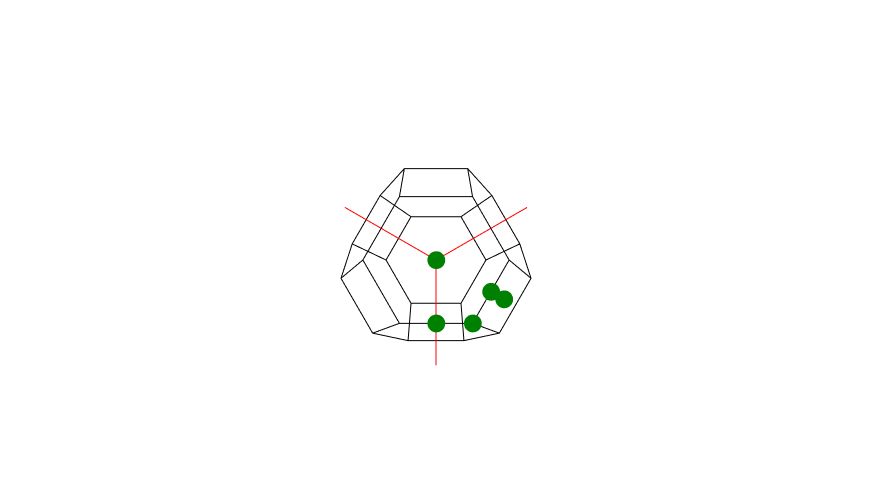

In [7]:
from matlantis_features.utils.visual_utils.brillouin_zone import get_brillouin_zone_3d

fig = get_brillouin_zone_3d(atoms.cell, show_reciprocal_basis=True, show_special_k_points=True)
fig.update_layout(width=600, height=500)

The crystall sillicon has a FCC lattice, and its first brillouin zone is a [truncated octahedron](https://en.wikipedia.org/wiki/Truncated_octahedron). The green dot in the figure indicates the high-symmetry points, e.g. K=[0.375, 0.375, 0.75]. Please check it by mouse-over the green dot in the above figure to show each label. The center of first brillouin zone in named as $\Gamma$ (or G) point.

To obtain all the allowed phonon frequency, we should calculate the phonon frequency at all $\vec q$ points that defines the first brillouin zone. However, a more common-used way is to represent the first brillouin zone by some high-symmetry path, such as the path connects $\Gamma$ and K points. The plot of phonon frequency along the high-symmetric path is called phonon dispersion.

In the next step, we use the `PostPhononBandFeature` in `matlantis-features` package to get the phonon dispersion of crystal Si.

### 2.4 Calculation of phonon dispersion

The `PostPhononBandFeature` uses the calculation result of `ForceConstantFeature`. We should specify the high symmetry path by the label of high symmetric points. Here, we calculate the path G -> X -> W -> K -> G -> L -> U -> W -> L -> K and U -> X.


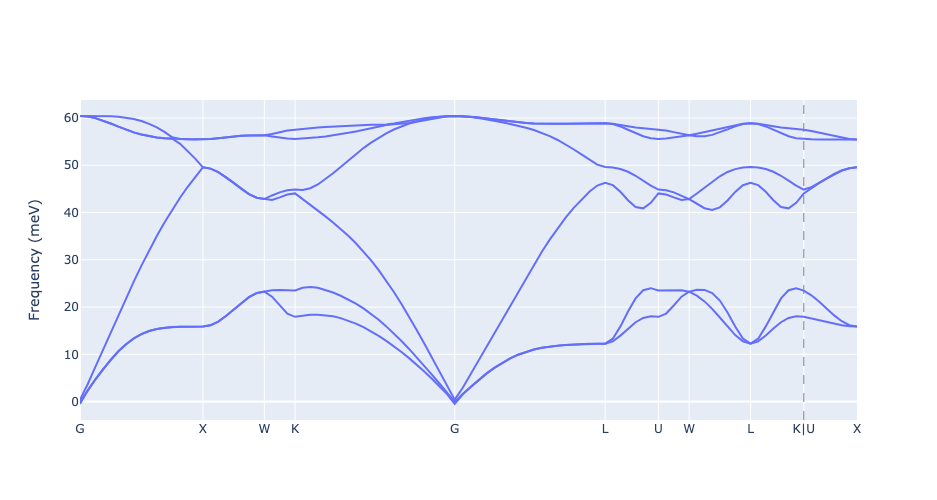

In [8]:
from matlantis_features.features.phonon import PostPhononBandFeature

band = PostPhononBandFeature()
band_results = band(
    force_constant, 
    labels = ['G', 'X', 'W', 'K', 'G', 'L', 'U', 'W', 'L', 'K', '|', 'U', 'X'], 
    total_n_kpts = 100,
)
fig = band_results.plot()
fig.update_layout(width=700, height=500)

We can see there are 6 branches in the phonon dispersion of sillicon (two branches may be degenerated into one at specific q points). It indicates there are 6 vibration modes for each wave vector.

The branches can be categorized as optical/accoustic branch according to the vibration mode. In addition, they can also be grouped as transverse and longitudinal branch according to the vibration mode propagation direction. In the next step, we analyze the type of phonon branch.

### 2.5 Phonon branch

**Optical and acoustic branch**

As explained above, we can get $3N$ vibration frequencies for a given $\vec q$. There will be $3N$ branches in the phonon dispersion. These branches can be classified into $3$ acoustic band and $3N-3$ optical bands.
The acoustic branches have the following characteristics:

- The acoustic branches have lower freqencies.
- The freqency of acoustic bands $\omega$ also goes to 0 at the center of Brillouin zone, i.e Gamma point. The slope $\frac{\partial \omega} {\partial q}$ gives the sound velocity.
- If we look at the lattice vibration of the acoustic band at $q=0$, we can see that the lattice move as a whole. This is just like the elastic wave.

The optical branches have the following characteristics:

- The optical branches have higher frequencies. 
- The neighboring atoms vibrate against each other in the optical mode.
- For the crystal containing multiple element, such as NaCl, the vibration between cation and anion (refer [ion](https://en.wikipedia.org/wiki/Ion#Anions_and_cations)) will cause the change in the total [dipole moment](https://en.wikipedia.org/wiki/Dipole). The dipole can interact with the externally applied electromagnetic waves. Hence, they are called optical modes.

In [9]:
from ipywidgets import HBox
from ase.visualize import view
from matlantis_features.features.phonon import PostPhononModeFeature
from pfcc_extras.visualize.povray import traj_to_apng

mode = PostPhononModeFeature()
mode_results = mode(
    force_constant,
    k_point=(0.1, 0.0, 0.0),
    repeat_of_cell=(4, 4, 4),
    n_images=30,
    amplitude=5.0
)

for i in range(6):
    traj_to_apng(mode_results.trajectories[i], f"output/vib.{i}.png", rotation="0x,0y,0z", clean=True, n_jobs=16)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   23.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:   22.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 co

**Acoustic vibration modes**
<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.0.png" alt="mode0">
  <figcaption>Mode #0</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.1.png" alt="mode1">
  <figcaption>Mode #1</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.2.png" alt="mode2">
  <figcaption>Mode #2</figcaption>
</figure>
</div>

**Optical vibration modes**
<div style="clear:both;display:table">
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.3.png" alt="mode3">
  <figcaption>Mode #3</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.4.png" alt="mode4">
  <figcaption>Mode #4</figcaption>
</figure>
<figure style="width:30%;float:left;margin:1px">
  <img src="./output/vib.5.png" alt="mode5">
  <figcaption>Mode #5</figcaption>
</figure>
</div>

We can clearly see that the atoms in band 0, 1 and 2 moves towards the same direction as a whole, while the atoms in band 3, 4, and 5 vibrate against each other. Thus, three phonon branches with lower frequencies are acoustic branches, and the other three phonon branches are optical branches.

**Transverse and Longitudinal branch**

The phonon branches can also be grouped into transverse and longitudinal branches according the direction of atom vibration and wave vector. In a transverse phonon mode, the atomic displacement is perpendicular to the wave vector $\vec q$. In a longitudinal phonon mode, the atomic displacement is parallel to the wave vector $\vec q$.


We can also determinate the vibration mode is longitudinal or transverse from follwing calculation.


In [10]:
reciprocal_basis = atoms.cell.reciprocal()
q_real = reciprocal_basis.dot(np.array([0.1, 0, 0]))

def get_angles(eigenvector, q_real):
    return np.arccos(eigenvector.dot(q_real) / np.linalg.norm(eigenvector, axis=1) / np.linalg.norm(q_real))

for i in range(6):
    angles = get_angles(eigenvector[i].real, q_real)
    print(f"Band {i}:")
    print(f"    Angles between q and eigenvectors:", angles)

Band 0:
    Angles between q and eigenvectors: [1.571 1.571]
Band 1:
    Angles between q and eigenvectors: [1.57 1.57]
Band 2:
    Angles between q and eigenvectors: [0.001 0.001]
Band 3:
    Angles between q and eigenvectors: [2.103e-03 3.140e+00]
Band 4:
    Angles between q and eigenvectors: [1.569 1.573]
Band 5:
    Angles between q and eigenvectors: [1.568 1.572]


We can see that $\vec{q}$ and eigenvectors are parallel in band 2 and 3, thus, they are longitudinal wave. On the contrary, $\vec{q}$ and eigenvectors are perpendicular to each other in band 0, 1, 4 and 5, and they are transverse wave.

In general, the 6 phonon branches of crystal silicon are:

- Transverse acoustic branch   (TA): branch 0 and 1
- Longitudinal acoustic branch (LA): branch 2
- Transverse optic branch      (TO): branch 4 and 5
- Longitudinal optic branch    (LO): branch 3

### 2.6 Phonon density of state (DOS)

Phonon dispersion can provide insight into material properties; however, the phonon dispersion is a non-trivial function in 3D and it is often helpful to bin modes by energy to simplify the description of what modes are present in a solid. As a consequence, we define the phonon density of states (DOS), which is the number of modes within $\omega$ to $\omega+d\omega$.

$$D(\omega) = \frac{1} {N} \sum_{m, \vec q} \delta (\omega - \omega_{m, \vec q})$$

Here, we use `PostPhononDOSFeature` to calculate the phonon DOS of crystal silicon

In [11]:
from matlantis_features.features.phonon import PostPhononDOSFeature, plot_band_dos

dos = PostPhononDOSFeature()
dos_results = dos(
    force_constant,
    kpts = [20,20,20],
    freq_min = -5.0,
    freq_max = 70.0,
    freq_bin =  1.0,
    scheme = "mp",
    unit = "meV"
)

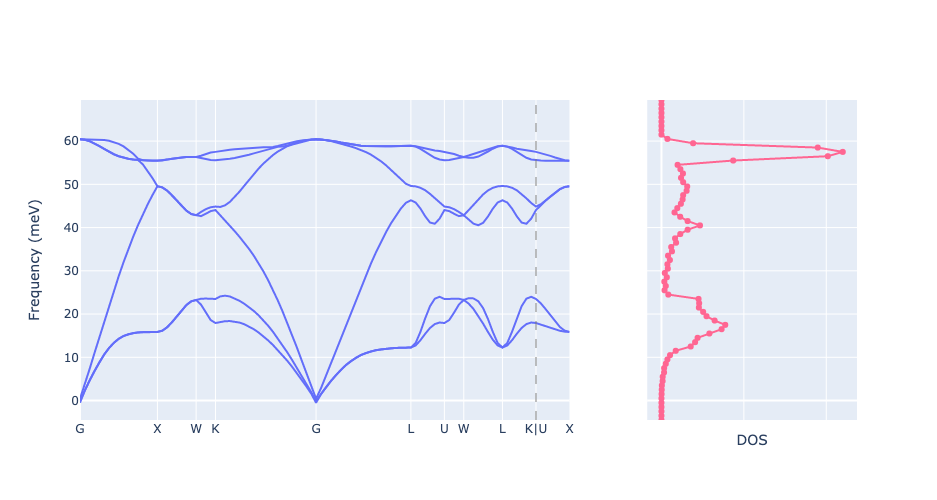

In [12]:
from plotly.offline import iplot

fig = plot_band_dos(band_results, dos_results)
fig.update_layout(width=1000, height=500)
iplot(fig)

The phonon dispersion and phonon DOS are diplayed togater in the above figure. In the `PostPhononDOSFeature`, we calculate the phonon frequencies on a uniform meshes of $\vec q$ points in the first Brillouin zone. Usually, the mesh grids can be Monkhorst-Pack scheme or Gamma-centered scheme. In the above example, a $20 \times 20 \times 20 $ Monkhorst-Pack style grid is used. Please refer to the [appendix](#section_5.3) for the detailed explaination of Phonon DOS.


### 2.7 Thermochemistry properties

As we mentioned, the thermal property of solid is closely related with phonon dispersion. Actually, as long as we know the phonon DOS, we can obtain several thermal properties, including specific heat $C_V$, entropy $S$, internal energy $U$ and Helmholtz free energy $A$.

The above properties are calculated with the following formula.

$$C_V = \int_{0}^{\infty} d {\omega} D(\omega) \; k_B\left( \frac{\hbar \omega}{k_B T} \right)^2 \frac{e^{\frac{\hbar \omega}{k_B T}}}{\left( e^{\frac{\hbar \omega}{k_B T}} - 1 \right)^2}$$

$$
S = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ ln \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} + 1  \right ) \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} + 1  \right ) - ln \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1}  \right ) \left( \frac {1}{e^{\frac{\hbar \omega}{k_B T}}-1} \right ) \right]
$$

$$ U = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + \frac {\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}} -1} \right] $$

$$A = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + k_BT ln \left( 1-e^{-\frac{\hbar \omega}{k_BT}} \right) \right]$$

[Note]

Phonon, which includes quantum effects, can only take discrete energies. It is known that phonon's temperature dependency (quantum statistics) is different compared to classical lattice vibration. Due to this fact, [Dirac constant](https://en.wikipedia.org/wiki/Planck_constant#Reduced_Planck_constant) $\hbar$ appeared in the above equations.

We can simply use the `PostPhononThermochemistryFeature` in the Matlantis-Features package to do the above calculation. Simlar to the `PostPhononDOSFeature`, we should define the mesh of $\vec q$ points. The `PostPhononThermochemistryFeature` will calculate the DOS from the force constant at first and then obtain the thermal properties according to the above formula.

In [13]:
from matlantis_features.features.phonon import PostPhononThermochemistryFeature

thermo = PostPhononThermochemistryFeature()
thermo_results = thermo(
    force_constant,
    kpts = [20, 20, 20],
    tmin = 0.0,
    tmax = 1000.0,
    tstep = 10.0,
    scheme = "mp",
)

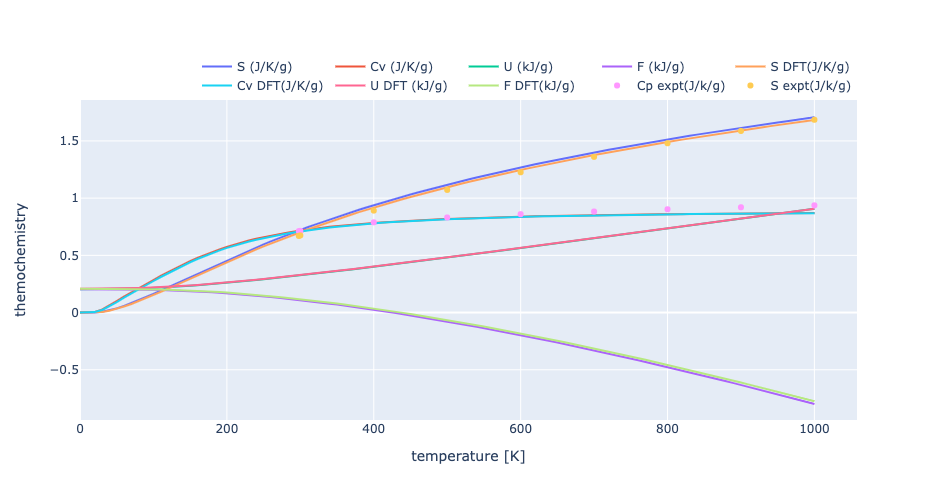

In [14]:
import pandas as pd
import plotly.graph_objects as go

thermo_dft = pd.read_csv("../assets/Si_thermo_dft.csv")
thermo_expt = pd.read_csv("../assets/Si_thermo_expt.csv")

fig = thermo_results.plot()
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["entropy"].loc[:100] / 28.09 / 2.,
        name = "S DFT(J/K/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["cv"].loc[:100] / 28.09 / 2.,
        name = "Cv DFT(J/K/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["internal_energy"].loc[:100] / 28.09 / 2./1000.,
        name = "U DFT (kJ/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_dft["T"].loc[:100],
        y = thermo_dft["helmholtz_free_energy"].loc[:100] / 28.09 / 2./1000.,
        name = "F DFT(kJ/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_expt["T"],
        y = thermo_expt["cp"],
        mode = "markers",
        name = "Cp expt(J/k/g)"
    )
)
fig.add_trace(
    go.Scatter(
        x = thermo_expt["T"],
        y = thermo_expt["entropy"],
        mode = "markers",
        name = "S expt(J/k/g)"
    )
)
fig.update_layout(width=800, height=500)

The calculation result is plotted in the above figure. We can see the result is agree with the [DFT](https://materialsproject.org/materials/mp-149/) and [experiment](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7440213&Units=SI&Mask=2#Thermo-Condensed) results.

DFT calculation results from

A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)  
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.  
[doi:10.1063/1.4812323](http://dx.doi.org/10.1063/1.4812323)  
[[bibtex]](https://materialsproject.org/static/docs/jain_ong2013.349ca3156250.bib)  
Licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  

Experiment results from

"Condensed Phase Heat Capacity Data" by Eugene S. Domalski and Elizabeth D. Hearing in NIST Chemistry WebBook, NIST Standard Reference Database Number 69, Eds. P.J. Linstrom and W.G. Mallard, National Institute of Standards and Technology, Gaithersburg MD, 20899, https://doi.org/10.18434/T4D303, (retrieved May, 2022).

<a id='section_3'></a>
## 3. Limitation of harmonic approximation

As shown in the above example, we can calculate the phonon dispersion, phonon DOS and some thermal properties of a crystal based on the harmonic approximation. However, such an approximation also hinder the application of phonon analysis in some physical properties since it totally ignores the anharmonicity of potential energy surface. The most important two aspects are thermal expansion and thermal conductivity.

**Thermal expansion**

Thermal expansion can not be directly obtained from the phonon analysis. It is because that the phonon calculation is based on the harmonic approximation, which assumes neighboring atoms are connected with perfect springs. In another word, the local potential energy surface is a quadratic function. But the real potential energy surface is actually not a quadratic function (please refer to the Fig 1 in chapter 4.1). If two atoms are connected with the perfect spring, the bond length will not increase when the temperature is higher. Thus the volume of solid will not increase with temperature. The thermal expansion is zero. 

However, the thermal expansion can be calculated from the [quasi-harmonic approximation](https://en.wikipedia.org/wiki/Quasi-harmonic_approximation). In the quasi-harmonic approximation, the phonon calculation is performed for a series of structures with compressesed or stretched lattice. The volume dependent properties, not only thermal expansion but also specific heat (Cp), Gibbs free energy (G) etc, can be obtained accordingly.

**Thermal conductivity**

Since the phonon carries energy and momentum. The thermal transportation can be explained as the movement of phonons in the crystal. However, since the phonon analysis is based on the harmonic approximation, the scattering between two phonons is ignored. In this case, one phonon can transport to a inifinite long distance without collision to another phonon, which leads to the infinite large thermal conductivity. As a consequence, we cannot get thermal conductivity from simple phonon calculation.

To consider the anharmonicity and phonon-phonon scattering, the third order Taylor series of potential energy should be considered.
$$E(\{\vec{R_{k}^{a}}\}) = E(\{\vec{R_{k,0}^{a}}\}) + \sum_{ak\alpha}{\sum_{bk'\beta}{\frac{1}{2} \left (\frac{\partial^2{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} + \sum_{ak\alpha}{\sum_{bk'\beta} \sum_{ck''\gamma} {\frac{1}{3!} \left (\frac{\partial^3{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}} \partial{u_{k''}^{c\gamma}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} u_{k''}^{c\gamma} $$
Thus, we should calculate the third order force constant, i.e. $\frac{\partial^3{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}} \partial{u_{k''}^{c\gamma}}}$. Several methods have been developed for the calculation of lattice thermal conductivity, such as real-time approximation.

<a id='section_4'></a>
## 4. References

[1] https://personales.unican.es/junqueraj/JavierJunquera_files/Metodos/Latticedynamics/Lattice-dynamics.pdf <br>
[2] http://www-personal.umich.edu/~sunkai/teaching/Winter_2013/chapter5.pdf <br>
[3] http://staff.ustc.edu.cn/~zqj/posts/LinearTetrahedronMethod/ <br>
[4] Otero-De-La-Roza, et. al.  Comput. Phys. Commun. 182, 2232–2248 (2011). <br>
[5] "Introduction to Solid State Physics" Charles Kittel <br>

<a id='section_5'></a>
## 5. Appendix

<a id='section_5.1'></a>

### 5.1 Formulations of phonon calculation

**Illustration**

<figure style="width:400px">
<img src="../assets/phonon-1-illustration.png"/>
</figure>

Before go to the formula deduction, we first show an 2D illustration of crystal structure. The meaning of several vectors in the figure is given as follow.

* $\vec{R^{a}}$ the vector from original point of original unit cell to the original point of unit cell $\mathit{a}$.
* $\vec{R_{k}^{a}}$ the vector from original point of original unit cell to the atom $\mathit{k}$ of unit cell $\mathit{a}$.
* $\vec{R_{k}}$ the vector from original point to the atom $\mathit{k}$ in the same unit cell.


**Harmonic approximation**

* Similar to the vibration calculation, the potential energy of system can be expressed as the following equation when atoms slightly deviated from the equilibrium position.

$$E(\{\vec{R_{k}^{a}}\}) = E(\{\vec{R_{k,0}^{a}}\}) + \sum_{ak\alpha}{\sum_{bk'\beta}{\frac{1}{2} \left (\frac{\partial^2{E}}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) }} u_{k}^{a\alpha} u_{k'}^{b\beta} $$

In this equation, $\vec {u^a}$ is the displacement of an atoms from its equilibrium position $\vec {R^a} - \vec {R_0^a}$, $\alpha$ and $\beta$ represent the cartesian directions, i.e. x, y and z.

* Please note that the harmonic approximation is valid only when atoms slightly displaced from its equilibrium position. That's why we can only get the low-temperature thermal properties of crystal from phonon analysis.

**Motion equation**

* The force act on the atom $\mathit{k}$ can be calculated from the derivative of the potential energy

$$\vec{F_{k}^{a\alpha}} = -\frac{E \left( \{R_{k}^{a} \} \right)}{\partial R_{k}^{a\alpha}} = -\frac{E \left( \{R_{k}^{a} \} \right)}{\partial u_{k}^{a\alpha}} = -\sum_{bk'\beta} \left ( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) u_{k'}^{b\beta}$$



* Acceleration of atom $\mathit{k}$

$$\vec{a_{k}^{a\alpha}} = \frac{\partial^2 u_{k}^{a\alpha}}{\partial t^2}$$

* So, the motion equation can be written as

$$ M_k \frac{\partial^2 u_{k}^{a\alpha}}{\partial t^2} = -\sum_{bk'\beta} \left ( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right ) u_{k'}^{b\beta} $$

* There are 3 motion equations for each atom. In total, there are $3N \times M$ equations for the system ($N$ is the number of atoms in a unit cell, and $M$ is the number of unit cells).
* The motion equations are coupled. 
The atomic displacement of the atom $k$ in the $a^{th}$ unit cell $u_{k}^{a\alpha}(t)$ depends on the $u_{k'}^{b\beta}$ of all the other atoms in the whole system.

**Assumption**

* To solve the above equations, we introduce two assumptions.
* 1. We assume that the $u_{k}^{a\alpha}(t)$ has the following format.
$$ u_{k}^{a\alpha}(t) = A_{k}^{\alpha} e^{-i\omega t} $$

        Considering that the equation might have multiple solutions, we add letter $\mathit{m}$ as the index of different solution.

$$ u_{k}^{a\alpha}(t) = A_{k, m}^{\alpha} e^{-i\omega_{m} t} \;\;\;  m={1, 2, ..., 3N} $$


* 2. Considering the perodical boundary condition, we assume the solution has the simlar format as plane wave,
which is, 

$$ u_{k}^{a\alpha}(t) = A_{k, m \vec{q}}^{\alpha} e^{i \vec{q} \vec{R_a}} e^{-i\omega_{m} t} $$

* With the above assumptions, the solution of the motion equation depends on a new parameter $\vec{q}$, which is the wavevector.

**Solve the motion equation**

* With the above assumptions, the motion equation can be writen as 

$$ M_{k} \omega_{m\vec{q}}^{2} A_{m\vec{q}}^{k\alpha} = \sum_{k'\beta} {\left[ \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} \right] A_{m\vec{q}}^{k'\beta}}$$


* Here, we define the force constant, which is a $3N \times 3N$ matrix, in a similar way as that in vibration analysis. However, considering the periodical boundary condition, the force constant between the unit $a$ and the unit $b$ is represented as follow.

$$
C^{a,b} = \begin{bmatrix}
 & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{0}^{bx}} & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{0}^{a x} \partial u_{N}^{bz}} \\ 
 & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{0}^{bx}} & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{0}^{a y} \partial u_{N}^{bz}} \\
 & ... & ... &  & ...\\ 
 & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{N}^{bx}} & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{0}^{by}} & ... & \frac{\partial ^2 E}{\partial u_{N}^{a z} \partial u_{N}^{bz}}
\end{bmatrix}
$$

* Considering the translational inveriant of the crystal lattice, the $C^{a,b} = C^{0, b-a}$

* In this case, the part between the brackets [...] in the motion equation can be regard as the discrete Fourier transform of the force constant in the real space.

$$ \tilde{C}_{\vec{q}}[k\alpha, k'\beta] = \sum_{b} {\left( \frac{\partial ^{2} E}{\partial{u_{k}^{a\alpha}} \partial{u_{k'}^{b\beta}}} \right) e^{i\vec{q}(\vec{R_b} - \vec{R_a})}} = \sum_{b} {C^{0,b}[k\alpha, k'\beta] e^{i\vec{q}(\vec{R_b} - \vec{R_a})}}$$

* To further simplify the motion equation, we define another $3N \times 3N$ matrix called the dynamics matrix 

$$ \tilde{D}_{\vec{q}}[k\alpha, k'\beta] = \frac{1}{\sqrt{M_k M_{k'}}} \tilde{C}(\vec{q})[k\alpha, k'\beta] $$


* Then, the motion equation for given $q$ vector can be simplified as a linear homogenous system of equations

$$ \boldsymbol{\tilde{D}_{\vec{q}}} \cdot \vec{\gamma}_{\vec{q}} = \omega^2_{\vec{q}} \vec{\gamma}_{\vec{q}}  $$

where, the $\vec{\gamma}_{\vec{q}}$ is called eigenvector, which is related with the amplitude of each atom by the following equation

$$ A_{k, m \vec{q}}^{\alpha} = \frac{1}{\sqrt{M_k}} \gamma_{k, m\vec{q}}^{\alpha} $$

* Diagonlize the dynamical matrix $\boldsymbol{\tilde{D}_{\vec{q}}}$, we can easily get the $3N$ vibration frequencies $\omega$ of the lattice for the given wave vector $\vec{q}$.

<a id='section_5.2'></a>
### 5.2 Why $\vec{q}$ is limited to first Brillouin zone?

We will explain why the  $\vec{q}$ is limited in the first Brillouin zone using an simple 1D case. 
Essentially, this limitation is originate from the discreted lattice points of the crystal atomic structure.

As we explained before, the atomic displacement of atom $a$ in a 1D lattice should be 

$$ u_{q}^{a}(t) = A e^{i q x_a} e^{-i\omega_{m} t} $$

Suppose that the coordinate of atoms $a$ is $x=0.0$, and the lattice constant is 1.0. Then the reciprocial lattice point $G \in (... -2\pi, 0, 2\pi, 4\pi, ...)$, and the first Brillouin zone is $[-\pi, \pi]$.

The following figure shows the $u_{q}^{a}(t)$ when $q$ is $-\pi/3$ (blue line), $-\pi/3+2\pi$ (green line) and $-\pi/3+4\pi$ (yellow line). We can see that the displacement of atoms $a$, which is indicated by the red dot, is exactly same in the three waves.

<figure style="width:400px">
<img src="../assets/phonon-2-why-first-brillouin-zone.gif"/>
</figure>

$u_{q}^{a}(t) = u_{q+G}^{a}(t)$

In another word, for any $\vec{q}$, there will be an equivalent $\vec{q}'$ in the first Brillouin zone which have the same displacement of atoms $u_{q}^{a}(t)$

<a id='section_5.3'></a>

### 5.3 Phonon density of state and thermochemistry properties

**Planck distribution**

In a solid, there will be many phonon excited at the same time. To get the thermal properies from phonon analysis, it is important to understand the distribution of phonon. The energy of a phonon is given by $E=\hbar\omega$. For a given phonon mode (fixed $\vec q$ and $\omega$) the probility of having $n$ phonons is $P(n)=\frac{1}{Z}e^{-\frac{n\hbar\omega}{k_B T}}$, where $Z$ is the normalization factor. So, the average number of phonons at given temperature $T$ can be expressed as

$$<n> = \sum_{0}^{\infty} {n P(n)} = \frac{1}{e^{\frac{\hbar\omega}{k_BT}}-1}$$
This is known as Planck distribution. The plot of planck distribution is given below.

<img src="../assets/phonon-3-planck_distribution.png" style="width:600px"/>


* From the left figure, we can see that the number of low-frequency phonon is much larger than that of high-frequency phonon, especially at the low temperature.
* From the right figure, we can see that the number of phonon will increase with the temperature. 

* The total energy carried by the phonon with frequency $\omega$ is simply obtained by:
$$<E_{\omega}> = <n> \hbar \omega = \frac{\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}}-1}$$

**Phonon density of state**

* One of the most important properties for a crystal system is its phonon density of states (DOS), which is defined by:
$$D(\omega) = \frac{1} {N} \sum_{m, \vec q} \delta (\omega - \omega_{m, \vec q})$$
in which, $m$ is the band index, $\vec q$ should walk through the first Brillouin zone.
The DOS $D(\omega)$ should follow the constraint
$$ N =\int_{0}^{\infty} D(\omega) d \omega $$
in which $N$ is the total number of phonon modes.


* If we know the density of states of phonon $D(\omega)$, we can easily get the energy contribution from phonon
$$ U' = \int_{0}^{\infty} d {\omega} D(\omega) E_{\omega} = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + \frac {\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}} -1} \right] = \int_{0}^{\infty} d {\omega} D(\omega) \frac{\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}}-1} $$
Note that the [zero-point energy](https://en.wikipedia.org/wiki/Zero-point_energy) of a phonon, just like the quantum harmonic oscillator, is $\frac {\hbar \omega}{2}$. If we include the zero point energy, the internal energy of a crystal can be expressed as
$$ U = \int_{0}^{\infty} d {\omega} D(\omega) \; \left[ \frac{\hbar \omega}{2} + \frac {\hbar \omega}{e^{\frac{\hbar \omega}{k_B T}} -1} \right] $$

* Many properties of the crystal can be related with the total internal energy $U$. For example the heat capacity $C_V$ is
$$C_V = \left( \frac{\partial U}{\partial T} \right)_V = \int_{0}^{\infty} d {\omega} D(\omega) Nk_B\left( \frac{\hbar \omega}{k_B T} \right)^2 \frac{e^{\frac{\hbar \omega}{k_B T}}}{\left( e^{\frac{\hbar \omega}{k_B T}} - 1 \right)^2}$$

* The specific heat $C_V$, entropy $S$, internal energy $U$ and Helmholtz free energy $A$ can be calculated from phonon DOS as well.

**How to get phonon density of states**

* From the above analysis, we can understand the many thermal properties can be obtained from the phonon density of states. But, how can we get the phonon DOS?
* Firstly, we should calculate the phonon frequencies on a uniform meshes of $\vec q$ points in the first Brillouin zone. Usually, the mesh grids can be Monkhorst-Pack scheme or Gamma-centered scheme.
* Then the phonon frequency is integrated over the first Brillouin zone. Usually two methods can be used, smearing method or tetrahedral integral method
    * In the tetrahedron method, the mesh grids are divided into tetrahedra. Within each tetrahedral, the phonon frequency can be interpolated linearly. In this way, the phonon DOS can be obtained analytically. [3]
    * In the smearing method, the gaussian smearing function is added to all the phonon frequencies get from the mesh grid of $\vec q$.